In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from sklearn.metrics import f1_score, matthews_corrcoef, roc_curve, roc_auc_score, classification_report, confusion_matrix, balanced_accuracy_score, recall_score, precision_score, precision_recall_curve

In [4]:
df = pd.read_csv("/Users/felipesantos/Desktop/diabetes_binary_health_indicators_BRFSS2015.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [5]:
X_all = df[[feat for feat in df.columns if feat != "Diabetes_binary"]]
Y_all = df["Diabetes_binary"]

[Text(0, 0, '218334'), Text(0, 0, '35346')]

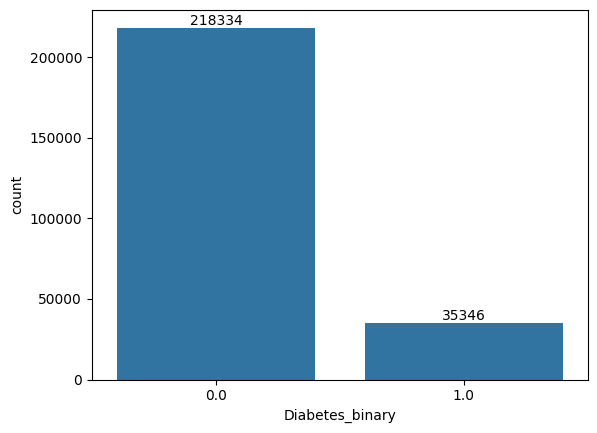

In [6]:
ax=sns.countplot(data=df, x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [7]:
# Dados reservados para validação final do modelo
X, X_test, Y, y_test = train_test_split(X_all, Y_all, test_size=0.1, random_state=416, stratify=Y_all)

[Text(0, 0, '196501'), Text(0, 0, '31811')]

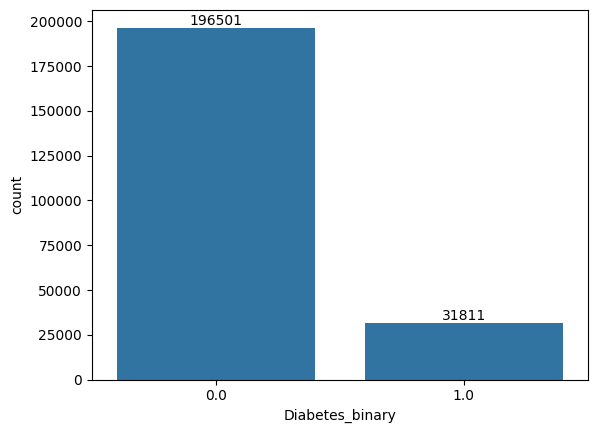

In [8]:
ax=sns.countplot(data=df.iloc[Y.index], x="Diabetes_binary")
ax.bar_label(ax.containers[0])

In [9]:
parameters = {
    'classifier__n_estimators':(50, 100, 200), 
    'classifier__criterion': ('gini', 'entropy', 'log_loss'),
    'classifier__max_depth': (5,10,20,None),
    'classifier__max_features': ('sqrt', 'log2')
}

In [ ]:
#best_params: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 
#'classifier__n_estimators': 50}

In [12]:
# Inicializar listas para armazenar as métricas
mccs, balan_accs, f1s, cms = [], [], [], []
precisions, recalls = [], []
tprs, fprs, aucs = [], [], []
mean_fpr = np.linspace(0, 1, 100)

# Loop de 100 iterações
for i in tqdm(range(1, 101)):
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = rus.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(
        class_weight="balanced_subsample", 
        max_depth=10, 
        n_estimators=50, 
        criterion="gini", 
        max_features="log2", 
        n_jobs=8
    )
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    y_pred = (y_pred_prob[:, 1] >= 0.5).astype(int)  # Converte as probabilidades em rótulos binários
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    f1s.append(f1)
    cms.append(confusion_matrix(Y_val, y_pred))
    fpr, tpr, thresholds = roc_curve(Y_val, y_pred_prob[:, 1])
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


In [13]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7493 +- 0.0018
ROC-AUC: 0.8259 +- 0.0017
MCC: 0.3592 +- 0.0027
F1: 0.4396 +- 0.0020
Precision: 0.3043 +- 0.0020
Recall: 0.7915 +- 0.0053


<Axes: >

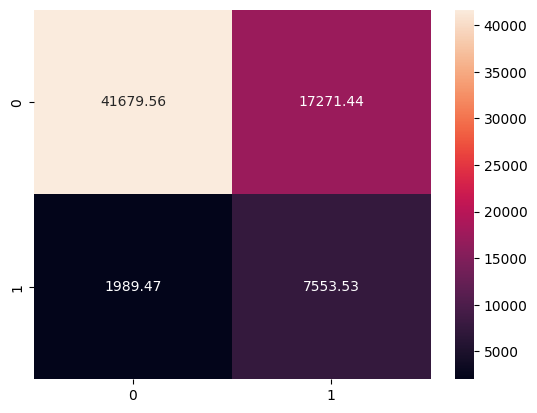

In [14]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

<Figure size 640x480 with 0 Axes>

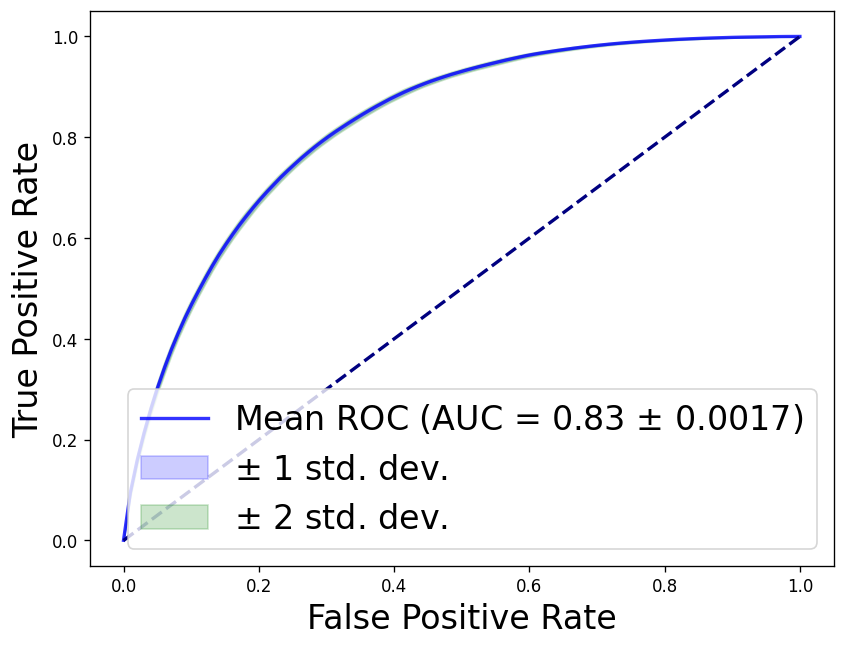

In [17]:
plt.figure()
# plt.style.use('seaborn-whitegrid')

lw = 2
plt.figure(figsize=(8, 6), dpi=120)

mean_tpr = np.mean(np.array(tprs), axis=0)
mean_fpr = np.linspace(0, 1, 100)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.4f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="blue",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr*2, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr*2, 0)

plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="green",
    alpha=0.2,
    label=r"$\pm$ 2 std. dev.",
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
# plt.title("Curva ROC", fontsize=20)
plt.legend(loc="lower right",prop={'size': 20})

In [18]:
# Simulação de dados
# X, Y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9], flip_y=0, random_state=42)

# Parâmetros
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [], [], [], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)

# Loop de 100 iterações
for i in tqdm(range(1, 101)):
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = rus.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(
        class_weight="balanced_subsample", 
        max_depth=10, 
        n_estimators=50, 
        criterion="gini", 
        max_features="log2", 
        n_jobs=8
    )
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    
    # Seleção do melhor threshold com base no F1 score
    scores = [f1_score(Y_val, (y_pred_prob[:, 1] >= t).astype(int)) for t in thresholds]
    melhor_threshold = thresholds[np.argmax(scores)]
    melhores_thresholds.append(melhor_threshold)
    
    # Previsão usando o melhor threshold
    y_pred = (y_pred_prob[:, 1] >= melhor_threshold).astype(int)
    
    # Cálculo das métricas
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [15:46<00:00,  9.46s/it]


In [19]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7250 +- 0.0043
ROC-AUC: 0.8258 +- 0.0017
MCC: 0.3719 +- 0.0033
F1: 0.4670 +- 0.0027
Precision: 0.3769 +- 0.0076
Recall: 0.6147 +- 0.0177


In [20]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.6325999999999999


<Axes: >

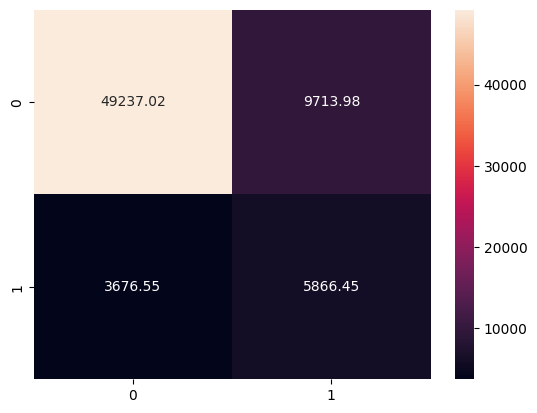

In [21]:
cms = np.array(cms)

sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

In [22]:
# Simulação de dados
# X, Y = make_classification(n_samples=1000, n_features=20, n_classes=2, weights=[0.1, 0.9], flip_y=0, random_state=42)

# Parâmetros
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [], [], [], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)

# Loop de 100 iterações
for i in tqdm(range(1, 101)):
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = rus.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(
        class_weight="balanced_subsample", 
        max_depth=10, 
        n_estimators=50, 
        criterion="gini", 
        max_features="log2", 
        n_jobs=8
    )
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    
    # Seleção do melhor threshold com base no Balanced Accuracy
    scores = [balanced_accuracy_score(Y_val, (y_pred_prob[:, 1] >= t).astype(int)) for t in thresholds]
    melhor_threshold = thresholds[np.argmax(scores)]
    melhores_thresholds.append(melhor_threshold)
    
    # Previsão usando o melhor threshold
    y_pred = (y_pred_prob[:, 1] >= melhor_threshold).astype(int)
    
    # Cálculo das métricas
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [24:01<00:00, 14.42s/it]


In [23]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7495 +- 0.0018
ROC-AUC: 0.8259 +- 0.0017
MCC: 0.3594 +- 0.0039
F1: 0.4395 +- 0.0047
Precision: 0.3040 +- 0.0064
Recall: 0.7935 +- 0.0142


In [24]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.4986


<Axes: >

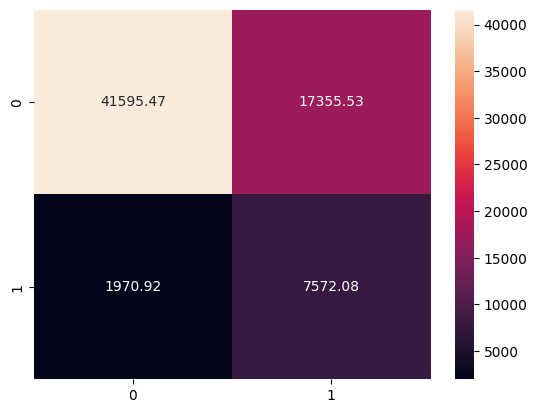

In [25]:
cms = np.array(cms)
sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")

In [26]:
# Parâmetros
thresholds = np.arange(0, 1, 0.01)
melhores_thresholds = []
mccs, balan_accs, f1s, cms = [], [], [], []
tprs, fprs, aucs = [], [], []
precisions, recalls = [], []
mean_fpr = np.linspace(0, 1, 100)

# Loop de 100 iterações
for i in tqdm(range(1, 101)):
    rus = RandomUnderSampler(sampling_strategy=1.0, random_state=416)
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=i, stratify=Y)
    X_train, Y_train = rus.fit_resample(X_train, Y_train)
    clf = RandomForestClassifier(
        class_weight="balanced_subsample", 
        max_depth=10, 
        n_estimators=50, 
        criterion="gini", 
        max_features="log2", 
        n_jobs=8
    )
    clf.fit(X_train, Y_train)
    y_pred_prob = clf.predict_proba(X_val)
    
    # Seleção do melhor threshold com base no MCC
    scores = [matthews_corrcoef(Y_val, (y_pred_prob[:, 1] >= t).astype(int)) for t in thresholds]
    melhor_threshold = thresholds[np.argmax(scores)]
    melhores_thresholds.append(melhor_threshold)
    
    # Previsão usando o melhor threshold
    y_pred = (y_pred_prob[:, 1] >= melhor_threshold).astype(int)
    
    # Cálculo das métricas
    mcc = matthews_corrcoef(Y_val, y_pred)
    mccs.append(mcc)
    balan_acc = balanced_accuracy_score(Y_val, y_pred)
    balan_accs.append(balan_acc)
    f1 = f1_score(Y_val, y_pred)
    f1s.append(f1)
    precisions.append(precision_score(Y_val, y_pred))
    recalls.append(recall_score(Y_val, y_pred))
    cms.append(confusion_matrix(Y_val, y_pred))
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(Y_val, y_pred_prob[:, 1], pos_label=1, drop_intermediate=True)
    inter_tpr = np.interp(mean_fpr, fpr, tpr)
    tprs.append(inter_tpr)
    aucs.append(roc_auc_score(Y_val, y_pred_prob[:, 1]))

100%|█████████████████████████████████████████| 100/100 [14:21<00:00,  8.62s/it]


In [27]:
print(f"ACC Balanceada: {np.mean(balan_accs):.4f} +- {np.std(balan_accs):.4f}")
print(f"ROC-AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}")
print(f"MCC: {np.mean(mccs):.4f} +- {np.std(mccs):.4f}")
print(f"F1: {np.mean(f1s):.4f} +- {np.std(f1s):.4f}")
print(f"Precision: {np.mean(precisions):.4f} +- {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} +- {np.std(recalls):.4f}")

ACC Balanceada: 0.7314 +- 0.0058
ROC-AUC: 0.8259 +- 0.0017
MCC: 0.3725 +- 0.0031
F1: 0.4660 +- 0.0031
Precision: 0.3656 +- 0.0114
Recall: 0.6446 +- 0.0273


In [28]:
print(f"Média do ponto de corte ótimo: {np.mean(melhores_thresholds)}")

Média do ponto de corte ótimo: 0.6143


<Axes: >

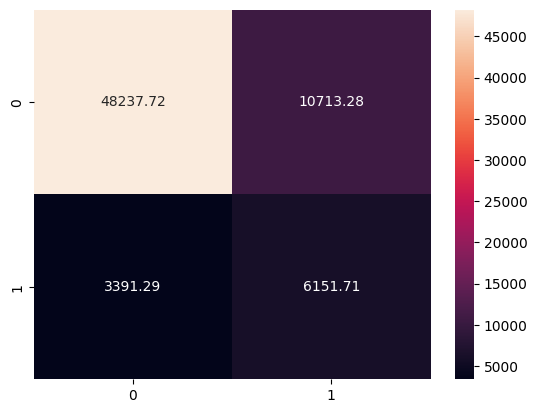

In [29]:
cms = np.array(cms)
sns.heatmap(cms.mean(axis=0), annot=True, fmt=".2f")